### KD Tree
#### 参考列表：
1. 《统计学习方法》李航
2. 《机器学习》周志华
3. Skywind-kNN的花式用法 (http://www.skywind.me/blog/archives/2308)
4. sk-learn-1.6. Nearest Neighbors (https://scikit-learn.org/stable/modules/neighbors.html#classification)

#### k近邻法(k-nearest neighbor, kNN)是一种基本的分类与回归方法，也是“懒惰学习”的典型代表，它没有显式的训练学习过程。对于新的输入实例，在训练样本中找到距离新输入实例最近的k个样本，通过多数表决或者加权平均的方法对新实例做出分类或者回归的预测。
#### k近邻法有如下三个要素：
- k值的选择； （可通过交叉验证选择一个合适的k值，也可由人凭经验指定）
- 距离的度量；（距离的度量有好多种，$L_p$，不同p值对应不同的度量方式，不同的度量方式可能会找出不同的最近邻点）
- 决策规则；(多数表决，加权平均)

#### 实现方法
- brute force：即线性扫描(linear scan)，要计算输入实例与每一个训练样本的距离，当样本量增大时，计算量也随之增大，计算非常耗时；
- kd tree(k dimensional tree): 将k维空间的样本点存储在一个二叉树中，实现了结构化存储，提高了k近邻的搜索效率；主要分为如下两部分：
    * 构建kd树；
    * 查找kd树；
- ball tree：（见balltree.ipynb）

#### 下面实现kd树

In [1]:
import numpy as np
from IPython.core.debugger import set_trace

In [2]:
# MaxHeapElem用于在最大堆中表示近邻
class MaxHeapElem:
    
    def __init__(self, kdtNode, distance):
        self.__tree_node = kdtNode # kd树中的节点
        self.__distance = distance # 节点与当前目标点的距离
    
    def __lt__(self, elem):
        return self.__distance < elem.distance()
    
    def __le__(self, elem):
        return self.__distance <= elem.distance()
    
    def __gt__(self, elem):
        return self.__distance > elem.distance()
    
    def __ge__(self, elem):
        return self.__distance >= elem.distance()
    
    def __eq__(self, elem):
        return self.__distance == elem.distance()
        
    def __ne__(self, elem):
        return self.__distance != elem.distance()
        
    def tree_node(self):
        return self.__tree_node
    
    def distance(self):
        return self.__distance
    pass


# MaxHeap4KNN是一个用于存储k近邻的最大堆
class MaxHeap4KNN:
    
    def __init__(self, k):
        self.k = k # 可存储的最大近邻个数, 即堆的最大容量
        self.heap = [''] * k # 堆空间
        self.nb_count = 0 # neighbor count, 堆中实际已存储的近邻数
        
        
    def is_full(self):
        return self.k == self.nb_count
    
    
    def farthest_neighbor_distance(self):
        if self.nb_count == 0:
            return np.inf
        
        return self.heap[0].distance()
    
    
    def add_neighbor(self, neighbor):
        
        if self.nb_count < self.k:
            # 尚未找到k个近邻，直接加入堆尾，然后上浮排序
            self.heap[self.nb_count] = neighbor
            self.nb_count += 1
            self.__float_up(self.nb_count - 1)
            
        elif neighbor < self.heap[0]:
            # 已找到k个近邻，neighbor比当前最远的近邻要近
            # 用neighbor替换当前最远的近邻，然后开始下沉排序
            self.heap[0] = neighbor
            self.__sink_down(0)
        pass
    
    
    def __sink_down(self, i):
        largest = i
        l = 2 * i + 1
        r = 2 * i + 2
        if l < self.nb_count and self.heap[largest] < self.heap[l]:
            largest = l
        if r < self.nb_count and self.heap[largest] < self.heap[r]:
            largest = r
            
        if largest != i:
            self.heap[largest], self.heap[i] = self.heap[i], self.heap[largest] # swap
            self.__sink_down(largest)
        pass
    
    
    def __float_up(self, i):
        if i == 0:
            return
        
        p = np.floor_divide(i - 1, 2)
        
        if self.heap[p] < self.heap[i]:
            self.heap[p], self.heap[i] = self.heap[i], self.heap[p] # swap
            self.__float_up(p)
        pass

In [3]:
# TreeNode表示kd树中的每个节点
class TreeNode:
    def __init__(self, feature, label, dim):
        self.left = None
        self.right = None
        self.feature = feature
        self.label = label
        self.dim = dim # partitioned dimension
    pass
# end of TreeNode

# KDTree
class KDTree:
    
    
    def __init__(self, K):
        self.K = K # 需要查找的近邻数
        self.__tree_root = None # kd树的根节点
        pass
    
    
    # ==============================构建kd树==============================
    
    # X: 参与本次划分的所有样本
    # y: 参与本次划分样本对应的标签
    # dim： 本次划分的特征空间维度
    def __partition_along_dim(self, X, fea_dims, dim):
        '''
        The KD tree is a binary tree structure which recursively partitions the parameter space along the data axes, 
        dividing it into nested orthotropic regions into which data points are filed. 
        '''
        dim = dim % fea_dims
        
        if X.shape[0] == 1:
            # 只有一个样本了，无需划分，直接作为叶子结点返回
            leaf = TreeNode(X[0][:-1], X[0][-1], dim)
            return leaf
        
        # 在特征维度dim上对样本X进行排序
        X = X[X[:, dim].argsort()]
        partition_pos = np.floor_divide(X.shape[0], 2) # 找到中间位置
        # 在当前划分维度dim上的特征值大于等于划分样本点的样本都归到右子树
        # 即如果样本空间有多个样本在划分维度dim上的值与中间位置样本的值相同
        # 那么取第一个重复值的样本作为本次的划分样本点
        for i in range(partition_pos - 1, -1, -1):
            if X[i][dim] != X[partition_pos][dim]:
                break
            partition_pos = i
        
        # 使用划分样本，创建当前节点
        node_x = X[partition_pos][:-1]
        node_y = X[partition_pos][-1]
        node = TreeNode(node_x, node_y, dim)
        
        # 用特征维度dim上的值小于划分样本点的样本构建左子树
        left_node_X = X[0:partition_pos]
        if left_node_X.shape[0]:
            node.left = self.__partition_along_dim(left_node_X, fea_dims, dim+1)
        
        # 用特征维度dim上的值大于等于划分样本的样本构建右子树
        right_node_X = X[partition_pos + 1:]
        if right_node_X.shape[0]:
            node.right = self.__partition_along_dim(right_node_X, fea_dims, dim+1)
        
        return node
    
    
    def fit(self, X, y):
        if X.shape[0] == 0 or X.shape[0] != y.shape[0]:
            return False
        
        # 为了构建树的方便，先将标签和特征合并到一起
        # 最后一列是标签
        feature_dims = X.shape[1]
        train_data = np.c_[X, y]
        # construct kd tree
        self.__tree_root = self.__partition_along_dim(train_data, feature_dims, 0)
        return True
    
    
    # ==============================在kd树上查找k近邻，预测==============================
    
    # 计算两个样本点之间的距离
    def __calc_distance(self, x1, x2):
        # 欧几里得距离
        return np.linalg.norm(x1 - x2)
    
    
    # 从start_point开始，比较目标实例x与每个节点在划分维度上的值，一沉到底
    # 返回沿途经过的节点队列，用于回溯
    def __search_down(self, start_point, x):
        point = start_point
        node_path = []
        while point:
            node_path.append(point)

            if x[point.dim] < point.feature[point.dim]:
                point  = point.left
                
            else:
                point = point.right
                
        return node_path
    
    
    # 根据node_path开始回溯
    # 如果最近邻不足k个，或者以x为圆心，当前k近邻中的最大距离为半径的超球体跟另一个子节点的空间相交
    # 则进入另一个子节点空间查找
    def __trace_back(self, node_path, x, knn):
        
        while len(node_path):
            node = node_path[-1]
            del node_path[-1]
            
            knn.add_neighbor(MaxHeapElem(node, self.__calc_distance(x, node.feature)))
            
            if x[node.dim] < node.feature[node.dim]:
                sibling_node = node.right
            else:
                sibling_node = node.left
            
            if not sibling_node:
                # 没有兄弟节点，直接回溯上一个节点
                continue
                
            if not knn.is_full():
                # 尚未找到k个近邻，需要进入兄弟节点查找
                return sibling_node
            
            farthest_nb_distance = knn.farthest_neighbor_distance()
            if farthest_nb_distance > np.abs(x[node.dim] - node.feature[node.dim]):
                # 以目标实例x为圆心，当前最远近邻的距离为半径的超球体与兄弟节点的空间相交，
                # 需要进入兄弟节点的空间继续查找
                return sibling_node
            
        return None 
    
        
    # 在kd树上找出离x最近的k个样本点
    def __search_knn(self, x):
        
        knn = MaxHeap4KNN(self.K)
        node_path = []
        
        point = self.__tree_root
        while point:
            
            # 从point开始，先一沉到底
            node_path.extend(self.__search_down(point, x))
            
            # 回溯查找
            point = self.__trace_back(node_path, x, knn)
            
            # 如果此处point为None，表示已经找个k个最近邻，直接返回结果
            # 否则point为需要继续查找的兄弟节点
            
        return knn
    
    
    def __predict_class(self, x):
        knn = self.__search_knn(x)
        labels = [elem.tree_node().label for elem in knn.heap]
        label_count = {}
        for label in labels:
            label_count.setdefault(label, 0)
            label_count[label] += 1
        predicted_label = sorted(label_count.items(), key=lambda x: x[1])[-1][0]
        return predicted_label
    
    
    def predict(self, X):
        if not self.__tree_root:
            return np.array([np.inf] * len(X))
        
        y = []
        for x in X:
            y.append(self.__predict_class(x))
    
        return np.array(y)
    



weights is uniform
CPU times: user 763 µs, sys: 177 µs, total: 940 µs
Wall time: 871 µs
CPU times: user 222 ms, sys: 32.7 ms, total: 254 ms
Wall time: 220 ms


weights is mykdtree-uniform
CPU times: user 5.9 ms, sys: 834 µs, total: 6.73 ms
Wall time: 18.1 ms
CPU times: user 45.1 s, sys: 579 ms, total: 45.6 s
Wall time: 48.5 s


weights is distance
CPU times: user 431 µs, sys: 70 µs, total: 501 µs
Wall time: 442 µs
CPU times: user 280 ms, sys: 27.3 ms, total: 308 ms
Wall time: 167 ms


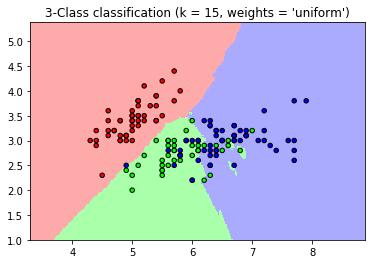

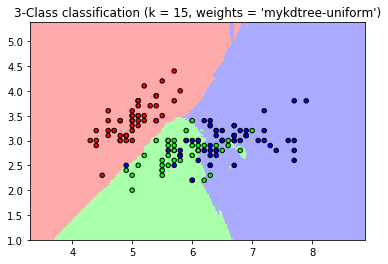

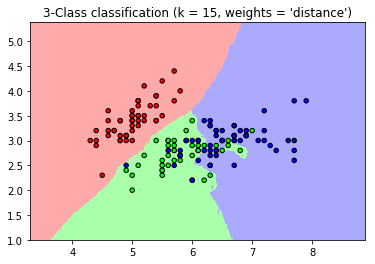

In [4]:
# 用sklearn中的例子，与sklearn的knn进行比较
# 原例子位置： https://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html#sphx-glr-auto-examples-neighbors-plot-classification-py

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets

n_neighbors = 15

# import some data to play with
iris = datasets.load_iris()

# we only take the first two features. We could avoid this ugly
# slicing by using a two-dim dataset
X = iris.data[:, :2]
y = iris.target

h = .02  # step size in the mesh

# Create color maps
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

for weights in ['uniform', 'mykdtree-uniform', 'distance']:
    print('\n\nweights is %s' % weights)
    # we create an instance of Neighbours Classifier and fit the data.
    if weights in ['mykdtree-uniform', ]:
        clf = KDTree(n_neighbors)
    else:
        clf = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)
    %time clf.fit(X, y)

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    %time Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold,
                edgecolor='k', s=20)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("3-Class classification (k = %i, weights = '%s')"
              % (n_neighbors, weights))

plt.show()
